![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Agents Lab Notebook v1.0.0
This notebook contains steps and code to demonstrate the use of agents
configured in Agent Lab in watsonx.ai. It introduces Python API commands
for authentication using API key and invoking a LangGraph agent with a watsonx chat model.

**Note:** Notebook code generated using Agent Lab will execute successfully.
If code is modified or reordered, there is no guarantee it will successfully execute.
For details, see: <a href="/docs/content/wsj/analyze-data/fm-prompt-save.html?context=wx" target="_blank">Saving your work in Agent Lab as a notebook.</a>

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Notebook goals
The learning goals of this notebook are:

* Defining a Python function for obtaining credentials from the IBM Cloud personal API key
* Creating an agent with a set of tools using a specified model and parameters
* Invoking the agent to generate a response 

# Setup

In [1]:
# import dependencies
from langchain_ibm import ChatWatsonx
from ibm_watsonx_ai import APIClient
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from ibm_watsonx_ai.foundation_models.utils import Tool, Toolkit
import json
import requests

## watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud personal API key. For details, see
<a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank">documentation</a>.


In [3]:
import os
import getpass

def get_credentials():
	return {
		"url" : "https://us-south.ml.cloud.ibm.com",
		"apikey" : getpass.getpass("Please enter your api key (hit enter): ")
	}

def get_bearer_token():
    url = "https://iam.cloud.ibm.com/identity/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = f"grant_type=urn:ibm:params:oauth:grant-type:apikey&apikey={credentials['apikey']}"

    response = requests.post(url, headers=headers, data=data)
    return response.json().get("access_token")

credentials = get_credentials()

Please enter your api key (hit enter):  ········


# Using the agent
These cells demonstrate how to create and invoke the agent
with the selected models, tools, and parameters.

## Defining the model id
We need to specify model id that will be used for inferencing:

In [4]:
model_id = "meta-llama/llama-3-3-70b-instruct"

## Defining the model parameters
We need to provide a set of model parameters that will influence the
result:

In [5]:
parameters = {
    "frequency_penalty": 0,
    "max_tokens": 2000,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

## Defining the project id or space id
The API requires project id or space id that provides the context for the call. We will obtain
the id from the project or space in which this notebook runs:

In [6]:
project_id = os.getenv("PROJECT_ID")
space_id = os.getenv("SPACE_ID")


## Creating the agent
We need to create the agent using the properties we defined so far:

In [7]:
client = APIClient(credentials=credentials, project_id=project_id, space_id=space_id)

# Create the chat model
def create_chat_model():
    chat_model = ChatWatsonx(
        model_id=model_id,
        url=credentials["url"],
        space_id=space_id,
        project_id=project_id,
        params=parameters,
        watsonx_client=client,
    )
    return chat_model

In [8]:
from ibm_watsonx_ai.deployments import RuntimeContext

context = RuntimeContext(api_client=client)




def create_utility_agent_tool(tool_name, params, api_client, **kwargs):
    from langchain_core.tools import StructuredTool
    utility_agent_tool = Toolkit(
        api_client=api_client
    ).get_tool(tool_name)

    tool_description = utility_agent_tool.get("description")

    if (kwargs.get("tool_description")):
        tool_description = kwargs.get("tool_description")
    elif (utility_agent_tool.get("agent_description")):
        tool_description = utility_agent_tool.get("agent_description")
    
    tool_schema = utility_agent_tool.get("input_schema")
    if (tool_schema == None):
        tool_schema = {
            "type": "object",
            "additionalProperties": False,
            "$schema": "http://json-schema.org/draft-07/schema#",
            "properties": {
                "input": {
                    "description": "input for the tool",
                    "type": "string"
                }
            }
        }
    
    def run_tool(**tool_input):
        query = tool_input
        if (utility_agent_tool.get("input_schema") == None):
            query = tool_input.get("input")

        results = utility_agent_tool.run(
            input=query,
            config=params
        )
        
        return results.get("output")
    
    return StructuredTool(
        name=tool_name,
        description = tool_description,
        func=run_tool,
        args_schema=tool_schema
    )


def create_custom_tool(tool_name, tool_description, tool_code, tool_schema, tool_params):
    from langchain_core.tools import StructuredTool
    import ast

    def call_tool(**kwargs):
        tree = ast.parse(tool_code, mode="exec")
        custom_tool_functions = [ x for x in tree.body if isinstance(x, ast.FunctionDef) ]
        function_name = custom_tool_functions[0].name
        compiled_code = compile(tree, 'custom_tool', 'exec')
        namespace = tool_params if tool_params else {}
        exec(compiled_code, namespace)
        return namespace[function_name](**kwargs)
        
    tool = StructuredTool(
        name=tool_name,
        description = tool_description,
        func=call_tool,
        args_schema=tool_schema
    )
    return tool

def create_custom_tools():
    custom_tools = []


def create_tools(context):
    tools = []
    
    config = None
    tools.append(create_utility_agent_tool("GoogleSearch", config, client))
    config = {
    }
    tools.append(create_utility_agent_tool("DuckDuckGo", config, client))

    return tools

In [9]:
def create_agent(context):
    # Initialize the agent
    chat_model = create_chat_model()
    tools = create_tools(context)

    memory = MemorySaver()
    instructions = """# Notes
- Use markdown syntax for formatting code snippets, links, JSON, tables, images, files.
- Any HTML tags must be wrapped in block quotes, for example ```<html>```.
- When returning code blocks, specify language.
- Sometimes, things don't go as planned. Tools may not provide useful information on the first few tries. You should always try a few different approaches before declaring the problem unsolvable.
- When the tool doesn't give you what you were asking for, you must either use another tool or a different tool input.
- When using search engines, you try different formulations of the query, possibly even in a different language.
- You cannot do complex calculations, computations, or data manipulations without using tools.
- If you need to call a tool to compute something, always call it instead of saying you will call it.

If a tool returns an IMAGE in the result, you must include it in your answer as Markdown.

Example:

Tool result: IMAGE({commonApiUrl}/wx/v1-beta/utility_agent_tools/cache/images/plt-04e3c91ae04b47f8934a4e6b7d1fdc2c.png)
Markdown to return to user: ![Generated image]({commonApiUrl}/wx/v1-beta/utility_agent_tools/cache/images/plt-04e3c91ae04b47f8934a4e6b7d1fdc2c.png)

 You are a research Agent, an AI system designed to assist with academic and scientific research tasks. You can autonomously search for literature, summarize papers, and organize references. 
Using natural language processing, you understand research questions and retrieve relevant information. 
You can generate reports, suggest hypotheses, and even draft sections of research papers. 
You save time by automating repetitive tasks like citation management and data extraction. 
Your job is to enhance efficiency, accuracy, and innovation in both academic and industrial R&D."""

    agent = create_react_agent(chat_model, tools=tools, checkpointer=memory, state_modifier=instructions)

    return agent

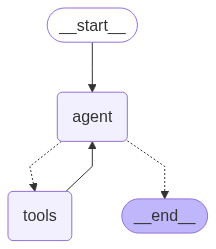

In [10]:
# Visualize the graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

Image(
    create_agent(context).get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
    )
)


## Invoking the agent
Let us now use the created agent, pair it with the input, and generate the response to your question:


In [11]:
agent = create_agent(context)

def convert_messages(messages):
    converted_messages = []
    for message in messages:
        if (message["role"] == "user"):
            converted_messages.append(HumanMessage(content=message["content"]))
        elif (message["role"] == "assistant"):
            converted_messages.append(AIMessage(content=message["content"]))
    return converted_messages

question = input("Question: ")

messages = [{
    "role": "user",
    "content": question
}]

generated_response = agent.invoke(
    { "messages": convert_messages(messages) },
    { "configurable": { "thread_id": "42" } }
)

print_full_response = False

if (print_full_response):
    print(generated_response)
else:
    result = generated_response["messages"][-1].content
    print(f"Agent: {result}")


Question:  Prepare a report for RAG develpoment for research


Failure during chat. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-07-09)
Status code: 403, body: {"errors":[{"code":"invalid_instance_status_error","message":"WML instance 9a466df5-a180-4ba7-94f1-d4be859db626 status is invalid, current status: Inactive, expected status: active","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai#text-chat"}],"trace":"65d6dd5b9c806a2cf7e0d676e86a2486","status_code":403}


ApiRequestFailure: Failure during chat. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-07-09)
Status code: 403, body: {"errors":[{"code":"invalid_instance_status_error","message":"WML instance 9a466df5-a180-4ba7-94f1-d4be859db626 status is invalid, current status: Inactive, expected status: active","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai#text-chat"}],"trace":"65d6dd5b9c806a2cf7e0d676e86a2486","status_code":403}

# Next steps
You successfully completed this notebook! You learned how to use
watsonx.ai inferencing SDK to generate response from the foundation model
based on the provided input, model id and model parameters. Check out the
official watsonx.ai site for more samples, tutorials, documentation, how-tos, and blog posts.

<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2024 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs (or equivalent) and License Information document for watsonx.ai Auto-generated Notebook (License Terms), such agreements located in the link below. Specifically, the Source Components and Sample Materials clause included in the License Information document for watsonx.ai Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="https://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF" target="_blank">License Terms</a>  